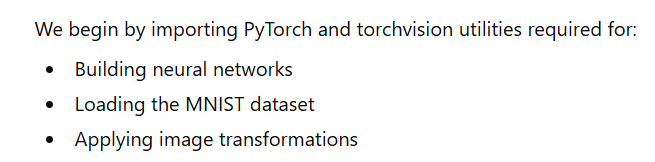

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

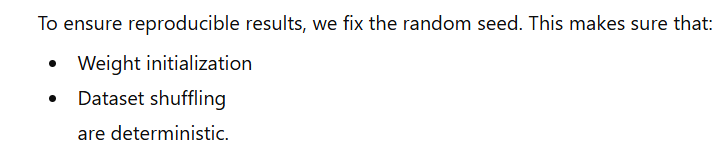

In [ ]:
# Make torch deterministic
_ = torch.manual_seed(0)

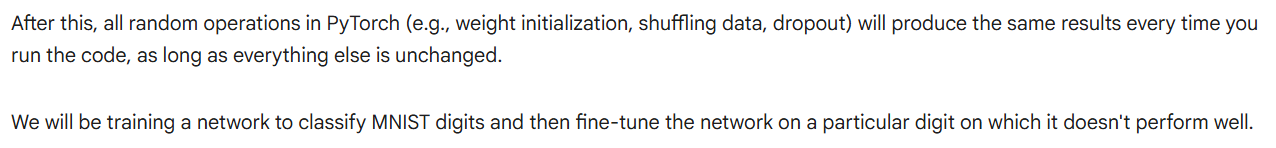

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


**Q1. Create the Neural Network to classify the digits. Make it overly complicated to better show the power of LoRA. This exaggeration creates a clear contrast when optimization techniques are applied.**

In [ ]:
# Create an overly expensive neural network to classify MNIST digits
# Daddy got money, so I don't care about efficiency
# Decide the values of hidden_size_1 and hidden_size_2 in the function before starting to code. Add more layers if you wish.
class RichBoyNet(nn.Module):
    def __init__(self, hidden_size_1, hidden_size_2):
        super(RichBoyNet,self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 10)
        #You can change the activation function if you want.
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x
hidden_size_1 = 2048
hidden_size_2 = 2048
net = RichBoyNet(hidden_size_1, hidden_size_2).to(device)

Train the network for **1 epoch** only to simulate a complete general Pre-Training on the data.

In [ ]:
def train(train_loader, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = net(x)
            loss = cross_el(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return

train(train_loader, net, epochs=1)

Epoch 1: 100%|██████████| 6000/6000 [00:33<00:00, 179.68it/s, loss=0.245]


Keep a copy of the original weights (clone them). So later on we can prove that fine-tuning with LoRA doesn't alter the original weights.

In [ ]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

Obtain the performance of the Pre-trained network. Choose a digit which your model fails to identify more often and start Fine Tuning the model to identify that digit better.

In [ ]:
def test():
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = net(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the digit {i}: {wrong_counts[i]}')

test()

Testing: 100%|██████████| 1000/1000 [00:03<00:00, 276.91it/s]

Accuracy: 0.959
wrong counts for the digit 0: 10
wrong counts for the digit 1: 19
wrong counts for the digit 2: 50
wrong counts for the digit 3: 22
wrong counts for the digit 4: 43
wrong counts for the digit 5: 59
wrong counts for the digit 6: 30
wrong counts for the digit 7: 77
wrong counts for the digit 8: 48
wrong counts for the digit 9: 49


Let's visualize how many parameters are present in the original network that you defined (Before introducing the LoRA matrices).

In [ ]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([2048, 784]) + B: torch.Size([2048])
Layer 2: W: torch.Size([2048, 2048]) + B: torch.Size([2048])
Layer 3: W: torch.Size([10, 2048]) + B: torch.Size([10])
Total number of parameters: 5,824,522


**Q2. Define the LoRA Parametrization as described in the paper "LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS". I have uploaded the paper on our repo.**
.
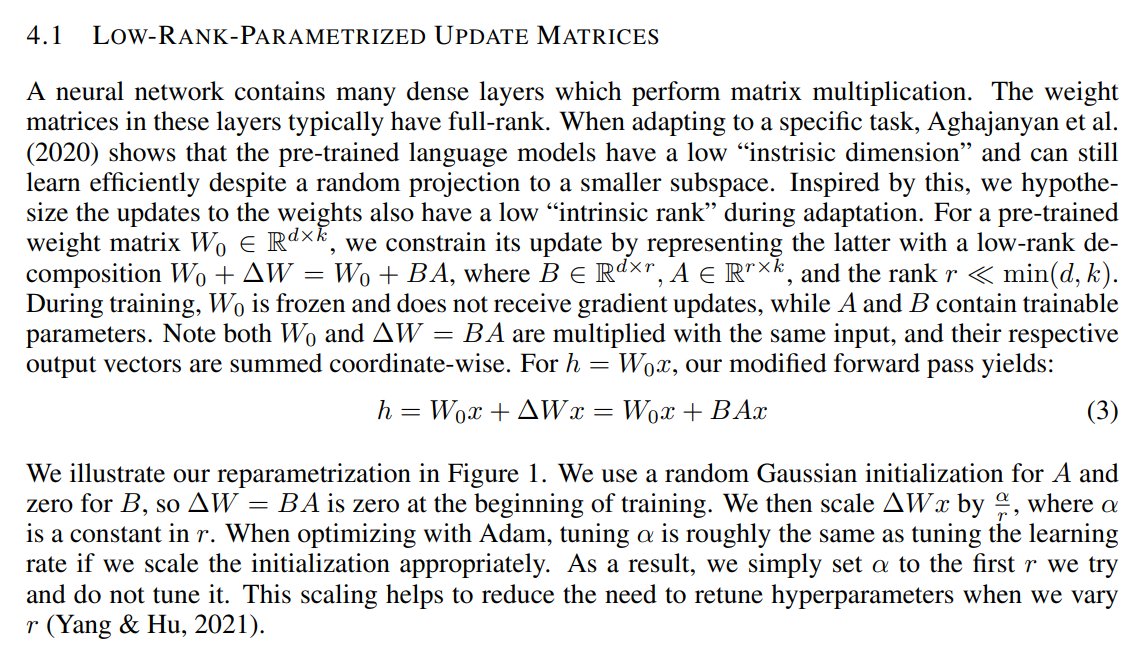


In [ ]:
class LoRAParametrization(nn.Module):
    def __init__(self, features_in, features_out, rank=1, alpha=1, device='cpu'):
        super().__init__()
        # Section 4.1 of the paper:
        #   We use a random Gaussian initialization for A and zero for B, so ∆W = BA is zero at the beginning of training
        self.lora_A = nn.Parameter(torch.zeros((rank,features_out)).to(device))
        self.lora_B = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        nn.init.normal_(self.lora_A, mean=0, std=1)

        # Section 4.1 of the paper:
        #   We then scale ∆Wx by α/r , where α is a constant in r.
        #   When optimizing with Adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately.
        #   As a result, we simply set α to the first r we try and do not tune it.
        #   This scaling helps to reduce the need to retune hyperparameters when we vary r.
        self.scale = alpha/rank
        self.enabled = True

    def forward(self, original_weights):
        if self.enabled:
            # Return W + (B*A)*scale
            return original_weights + (self.lora_B @ self.lora_A) * self.scale
        else:
            return original_weights

Add the parametrization to our network.

In [ ]:
import torch.nn.utils.parametrize as parametrize

def linear_layer_parameterization(layer, device, rank=1, lora_alpha=1):
    # Only add the parameterization to the weight matrix, ignore the Bias

    # From section 4.2 of the paper:
    #   We limit our study to only adapting the attention weights for downstream tasks and freeze the MLP modules (so they are not trained in downstream tasks) both for simplicity and parameter-efficiency.
    #   [...]
    #   We leave the empirical investigation of [...], and biases to a future work.

    features_in, features_out = layer.weight.shape
    return LoRAParametrization(
        features_in, features_out, rank=rank, alpha=lora_alpha, device=device
    )

parametrize.register_parametrization(
    net.linear1, "weight", linear_layer_parameterization(net.linear1, device)
)
parametrize.register_parametrization(
    net.linear2, "weight", linear_layer_parameterization(net.linear2, device)
)
parametrize.register_parametrization(
    net.linear3, "weight", linear_layer_parameterization(net.linear3, device)
)


def enable_disable_lora(enabled=True):
    for layer in [net.linear1, net.linear2, net.linear3]:
        layer.parametrizations["weight"][0].enabled = enabled

Display the number of parameters added by LoRA.

In [ ]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )
# The non-LoRA parameters count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W: torch.Size([2048, 784]) + B: torch.Size([2048]) + Lora_A: torch.Size([1, 784]) + Lora_B: torch.Size([2048, 1])
Layer 2: W: torch.Size([2048, 2048]) + B: torch.Size([2048]) + Lora_A: torch.Size([1, 2048]) + Lora_B: torch.Size([2048, 1])
Layer 3: W: torch.Size([10, 2048]) + B: torch.Size([10]) + Lora_A: torch.Size([1, 2048]) + Lora_B: torch.Size([10, 1])
Total number of parameters (original): 5,824,522
Total number of parameters (original + LoRA): 5,833,508
Parameters introduced by LoRA: 8,986
Parameters incremment: 0.154%



**Q3. Freeze all the parameters of the original network and only fine tuning the ones introduced by LoRA. Then fine-tune the model on the digit you selected above and only for 100 batches.**

In [ ]:
# Freeze the non-Lora parameters
for name, param in net.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False

# Load the MNIST dataset again, by keeping only the digit you have selected.
target_digit = 7
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
exclude_indices = mnist_trainset.targets == target_digit
mnist_trainset.data = mnist_trainset.data[exclude_indices]
mnist_trainset.targets = mnist_trainset.targets[exclude_indices]
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Train the network with LoRA only on the digit and only for 100 batches (hoping that it would improve the performance on the digit)
train(train_loader, net, epochs=1, total_iterations_limit=100)

Freezing non-LoRA parameter linear1.bias
Freezing non-LoRA parameter linear1.parametrizations.weight.original
Freezing non-LoRA parameter linear2.bias
Freezing non-LoRA parameter linear2.parametrizations.weight.original
Freezing non-LoRA parameter linear3.bias
Freezing non-LoRA parameter linear3.parametrizations.weight.original


Epoch 1:  99%|█████████▉| 99/100 [00:00<00:00, 151.30it/s, loss=0.126]


Verify that the fine-tuning didn't alter the original weights, but only the ones introduced by LoRA

In [ ]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(net.linear1.parametrizations.weight.original == original_weights['linear1.weight'])
assert torch.all(net.linear2.parametrizations.weight.original == original_weights['linear2.weight'])
assert torch.all(net.linear3.parametrizations.weight.original == original_weights['linear3.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(net.linear1.weight, net.linear1.parametrizations.weight.original + (net.linear1.parametrizations.weight[0].lora_B @ net.linear1.parametrizations.weight[0].lora_A) * net.linear1.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(net.linear1.weight, original_weights['linear1.weight'])

Test the network with LoRA enabled (the digit you selected should be classified better).

In [ ]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test()

Testing: 100%|██████████| 1000/1000 [00:03<00:00, 271.20it/s]

Accuracy: 0.957
wrong counts for the digit 0: 19
wrong counts for the digit 1: 25
wrong counts for the digit 2: 66
wrong counts for the digit 3: 32
wrong counts for the digit 4: 42
wrong counts for the digit 5: 51
wrong counts for the digit 6: 28
wrong counts for the digit 7: 17
wrong counts for the digit 8: 64
wrong counts for the digit 9: 90


Test the network with LoRA disabled (the accuracy and errors counts must be the same as the original network).

In [ ]:
# Test with LoRA disabled
enable_disable_lora(enabled=False)
test()

Testing: 100%|██████████| 1000/1000 [00:03<00:00, 265.66it/s]

Accuracy: 0.959
wrong counts for the digit 0: 10
wrong counts for the digit 1: 19
wrong counts for the digit 2: 50
wrong counts for the digit 3: 22
wrong counts for the digit 4: 43
wrong counts for the digit 5: 59
wrong counts for the digit 6: 30
wrong counts for the digit 7: 77
wrong counts for the digit 8: 48
wrong counts for the digit 9: 49
